In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

In [2]:
# path = r"C:\Users\aredd\Downloads\spam.csv"
path2 = r"C:\Users\aredd\Desktop\MailImportance-ProjecctZ\Data\enron_spam_data.csv"

df = pd.read_csv(path2,encoding='latin')

In [3]:
df.head()

,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14


In [4]:
df.drop('Message ID',axis=1,inplace=True)

In [5]:
df['text'] = df['Date'] + ' ' + df['Subject']  + ' ' + df['Message']

df.drop(columns=['Message','Date','Subject'],axis=1,inplace=True)
df.dropna(inplace=True)

In [6]:
df.rename(columns={'Spam/Ham':"spam"},inplace=True)

In [7]:
df['spam'] = df['spam'].map({'ham':0,'spam':1})

In [8]:
(df['spam'] == 1).sum(),(df['spam'] == 0).sum()

(16614, 16493)

In [9]:
ham = (df[df['spam'] == 0]).head(1368)
spam = df[df['spam'] == 1]

final_df = pd.concat([ham,spam],ignore_index=True,axis=0)
final_df = final_df.sample(frac=1)

In [10]:
final_df = df

In [162]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk


stop_words = list(set(stopwords.words('english')))

def process_text(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9]',' ',text)
    text = [x for x in word_tokenize(text) if x not in stop_words and len(x) > 2]

    return text 

In [12]:
final_df['processed_text'] = final_df['text'].apply(process_text)

In [13]:
from gensim.models import Word2Vec

model_emb = Word2Vec(sentences=final_df['processed_text'], vector_size=100, window=10, min_count=1, sg=0)

def get_embeddings(tokens):
    embeddings = [model_emb.wv[word] for word in tokens if word in model_emb.wv]
    if embeddings:
        return sum(embeddings) / len(embeddings)
    else:
        return None

final_df['embeddings'] = final_df['processed_text'].apply(get_embeddings)

In [14]:
final_df.head()

,spam,text,processed_text,embeddings
1,0,"1999-12-13 vastar resources , inc . gary , pro...","[1999, vastar, resources, inc, gary, productio...","[-0.756693, 0.81156284, -0.414154, 0.2456175, ..."
2,0,1999-12-14 calpine daily gas nomination - calp...,"[1999, calpine, daily, gas, nomination, calpin...","[-1.0756443, -0.930206, -0.8945571, 0.33256105..."
3,0,1999-12-14 re : issue fyi - see note below - a...,"[1999, issue, fyi, see, note, already, done, s...","[0.0037972054, 1.8204271, -0.9978659, 0.371516..."
4,0,1999-12-14 meter 7268 nov allocation fyi .\n- ...,"[1999, meter, 7268, nov, allocation, fyi, forw...","[-0.029128803, 1.618269, -0.993489, 0.81147724..."
5,0,"1999-12-14 mcmullen gas for 11 / 99 jackie ,\n...","[1999, mcmullen, gas, jackie, since, inlet, ri...","[-0.7826631, 0.3658283, -0.64667875, 0.3469996..."


In [15]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33107 entries, 1 to 33715
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   spam            33107 non-null  int64 
 1   text            33107 non-null  object
 2   processed_text  33107 non-null  object
 3   embeddings      33107 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.3+ MB


In [16]:
final_df.reset_index(inplace=True,drop=True)

In [17]:
# from yake import KeywordExtractor

# final_df['extracted_keywords'] = ""
# final_df['keyword_scores'] = ""

# keyword_extractor = KeywordExtractor(lan="en", n=2, top=10)

# def extract_keywords_yake(text):
#     # Extract keywords from the text
#     keywords = keyword_extractor.extract_keywords(text)
#     keyword_scores = [score for _, score in keywords]
#     extracted_keywords = [keyword for keyword, _ in keywords]
#     return keyword_scores, extracted_keywords

# lst_keywords_scores = []
# lst_keywords = []

# for i in final_df['processed_text']:
#     score,key = extract_keywords_yake(' '.join(i))
#     lst_keywords.append(key)
#     lst_keywords_scores.append(score)

# final_df['extracted_keywords'] = lst_keywords
# final_df['keyword_scores'] = lst_keywords_scores

In [18]:
from sklearn.cluster import KMeans

X = np.array(final_df['embeddings'].to_list())
wcss = list()

for i in range(1,6):
    model_km = KMeans(n_clusters=i,init='k-means++')
    model_km.fit(X)
    wcss.append(model_km.inertia_)

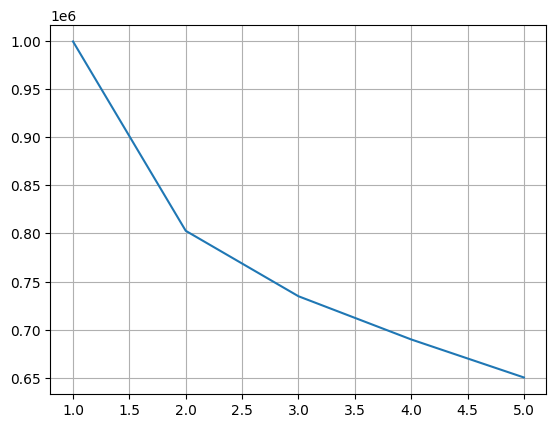

In [19]:
import matplotlib.pyplot as plt

plt.grid()
plt.plot(range(1,6),wcss)

In [20]:
model_kmeans = KMeans(n_clusters=2,init='k-means++')
model_kmeans.fit(X)

labels = model_kmeans.predict(X)

In [21]:
from sklearn.decomposition import PCA

model_pca = PCA(n_components=2)
X_pca = model_pca.fit_transform(np.array(final_df['embeddings'].to_list()))

In [22]:
cluster_centriods = model_pca.fit_transform(model_kmeans.cluster_centers_)

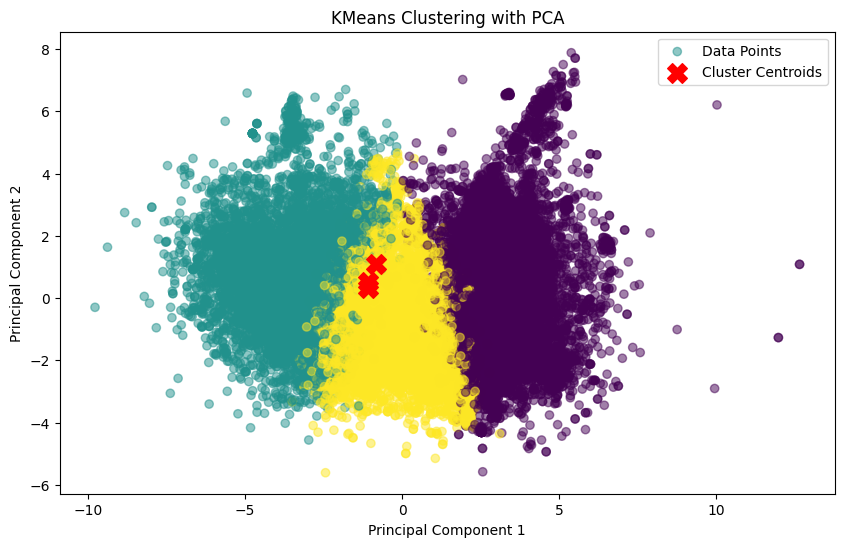

In [142]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.5, label='Data Points')
plt.scatter(cluster_centriods[:, 0], cluster_centriods[:, 1], marker='X', s=200, c='red', label='Cluster Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering with PCA')
plt.legend()
plt.show()

In [24]:
cluster_centriods

array([[-2.4465518e+00,  2.8424776e-07],
       [ 2.4465525e+00,  2.8424770e-07]], dtype=float32)

<AxesSubplot: ylabel='Count'>

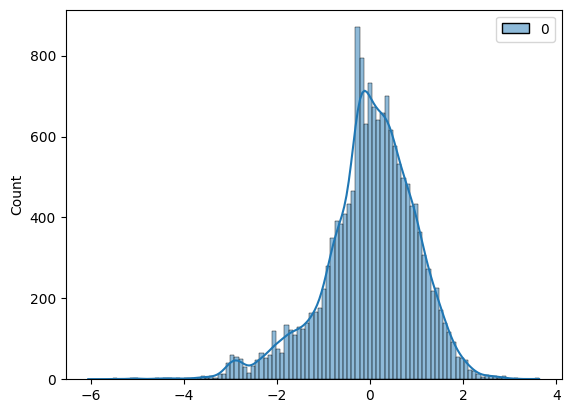

In [25]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings_sum = final_df[final_df['spam'] == 0].embeddings.apply(np.sum)
scaled_embeddings_sum = scaler.fit_transform(embeddings_sum.values.reshape(-1, 1))

sns.histplot(scaled_embeddings_sum, kde=True)

<AxesSubplot: ylabel='Count'>

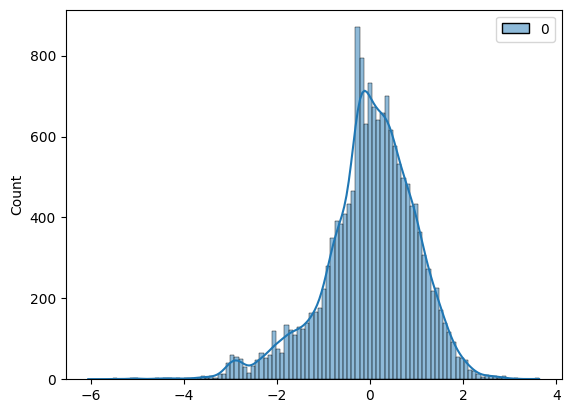

In [26]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings_sum = final_df[final_df['spam'] == 0].embeddings.apply(np.sum)
scaled_embeddings_sum = scaler.fit_transform(embeddings_sum.values.reshape(-1, 1))

sns.histplot(scaled_embeddings_sum, kde=True)

In [27]:
final_df['weighted_imps'] = (np.sum(X_pca @ cluster_centriods,axis=1))

<AxesSubplot: xlabel='weighted_imps', ylabel='Count'>

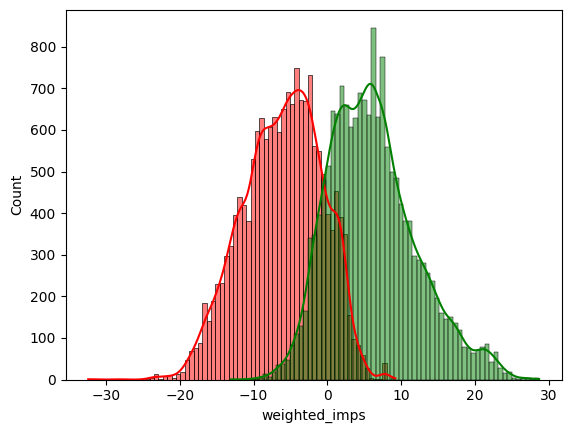

In [28]:
sns.histplot(final_df[final_df['spam']==1]['weighted_imps'], kde=True,color='red')
sns.histplot(final_df[final_df['spam']==0]['weighted_imps'], kde=True,color='green')

In [159]:
emails = [
    "Subject: Urgent Meeting Tomorrow\nHi team,\nJust a quick heads up that we have an urgent meeting scheduled for tomorrow morning at 10 AM. The management wants to discuss the progress of the ongoing project and make some crucial decisions. Please make sure you come prepared with all the necessary information.\nBest regards,\nAlex",
    
    "Subject: Congratulations on the Promotion\nHey [Friend's Name],\nI wanted to be the first to congratulate you on your well-deserved promotion! Your dedication and hard work have paid off, and I couldn't be happier for you. Let's celebrate your success soon.\nCheers,\nEmily",
    
    "Subject: Exciting Travel Opportunity\nHello [Friend's Name],\nHow would you like to embark on an exciting adventure? I've come across an amazing travel deal for a tropical destination. Imagine relaxing on the pristine beaches and exploring vibrant local culture. Let's plan a memorable getaway together.\nTake care,\nJames",
    
    "Subject: Important Project Update\nHi [Client's Name],\nI hope this email finds you well. I wanted to provide you with an important update regarding the project. Our team has successfully completed the initial phase, and we're eager to move forward with the next steps. Your input has been invaluable in shaping the project's direction.\nWarm regards,\nSarah",
    
    "Subject: Exclusive Offer: 50% Off!\nDear valued customer,\nDon't miss out on our exclusive limited-time offer! Get 50% off on selected items. Click the link below to start shopping.\n",
    
    "Subject: Your Account Verification\nHello [Your Name],\nWe noticed some unusual activity on your account. To ensure the security of your account, please verify your information by clicking the link below.\n",
    
    "Subject: Unbelievable Investment Opportunity\nHi,\nAre you tired of working for a living? Invest in our revolutionary program and become a millionaire within weeks! Don't miss this once-in-a-lifetime opportunity.\n",
    
    "Subject: Your Recent Purchase\nDear [Your Name],\nThank you for your recent purchase. Your order has been confirmed and will be shipped soon. If you have any questions, please contact our customer support.\n",
    
    "Subject: Urgent: Action Required\nDear user,\nYour account is at risk! We have detected suspicious activity. Please log in to your account and change your password immediately.\n",
    
    "Subject: Exclusive Invitation: VIP Event\nHello [Your Name],\nYou're invited to an exclusive VIP event. Join us for an evening of networking, entertainment, and more. RSVP now to secure your spot!\n",
    
    "Subject: Free Trial Offer\nHi there,\nTry our premium service for free with a 7-day trial. Experience the benefits firsthand and see how it can transform your life.\n",
    
    "Subject: Important Notice: Account Closure\nDear [Your Name],\nWe regret to inform you that your account will be closed due to inactivity. If you wish to keep your account, please log in within the next 24 hours.\n",
    
    "Subject: Exclusive Discount Code Inside\nHi [Your Name],\nAs a valued customer, we're giving you an exclusive discount code for your next purchase. Use code 'EXCLUSIVE20' to get 20% off!\n",
    
    "Subject: Your Opinion Matters\nHello,\nWe value your feedback! Take a short survey and share your thoughts for a chance to win exciting prizes.\n",
    
    "Subject: Special Offer for Subscribers\nHi Subscriber,\nYou're receiving this email because you're a valued subscriber. Enjoy a special discount on our latest product.\n",
    
    "Subject: Important Tax Information\nDear [Your Name],\nTax season is here. Access your important tax documents by logging in to your account.\n",
    
    "Subject: You're a Winner!\nCongratulations,\nYou're the lucky winner of our monthly giveaway! Claim your prize by clicking the link below.\n",
    
    "Subject: Limited Time Offer: Buy One, Get One Free\nHi [Your Name],\nDon't miss our limited-time offer. Buy one item and get a second one for free!\n",
    
    "Subject: Your Account Has Been Suspended\nHello [Your Name],\nWe're sorry to inform you that your account has been suspended due to policy violations. Please contact our support team for more information.\n",
    
    "Subject: Stay Healthy and Fit\nHi there,\nLooking to get in shape? Check out our fitness program and start your journey to a healthier lifestyle.\n",
    
    "Subject: Claim Your Inheritance\nDear [Your Name],\nYou've been named the beneficiary of a substantial inheritance. To claim it, simply provide your personal information.\n"
]


# saving Model 

In [30]:
# import joblib
# import os

# path = r"C:\Users\aredd\Desktop\MailImportance-ProjecctZ\Models"
# model_filename = os.path.join(path,'kmeans_model.model')
# joblib.dump(model_kmeans, model_filename)

# model_filename =  os.path.join(path,'word2vec_model.model')
# model_emb.save(model_filename)

# model_filename =  os.path.join(path,'pca_model.model')
# joblib.dump(model_pca, model_filename)

# saving Processed Data

In [31]:
# path_data = r"C:\Users\aredd\Desktop\MailImportance-ProjecctZ\Data"

# final_df.to_csv(os.path.join(path_data,'Final_Data.csv'),index=False)

# final_df['embeddings'] = np.array(final_df['embeddings'].to_list())

In [32]:
final_df.head()

,spam,text,processed_text,embeddings,weighted_imps
0,0,"1999-12-13 vastar resources , inc . gary , pro...","[1999, vastar, resources, inc, gary, productio...","[-0.756693, 0.81156284, -0.414154, 0.2456175, ...",9.329062
1,0,1999-12-14 calpine daily gas nomination - calp...,"[1999, calpine, daily, gas, nomination, calpin...","[-1.0756443, -0.930206, -0.8945571, 0.33256105...",15.419380
2,0,1999-12-14 re : issue fyi - see note below - a...,"[1999, issue, fyi, see, note, already, done, s...","[0.0037972054, 1.8204271, -0.9978659, 0.371516...",15.974284
3,0,1999-12-14 meter 7268 nov allocation fyi .\n- ...,"[1999, meter, 7268, nov, allocation, fyi, forw...","[-0.029128803, 1.618269, -0.993489, 0.81147724...",18.347486
4,0,"1999-12-14 mcmullen gas for 11 / 99 jackie ,\n...","[1999, mcmullen, gas, jackie, since, inlet, ri...","[-0.7826631, 0.3658283, -0.64667875, 0.3469996...",6.926797


# Testing 

In [33]:
def return_sorted(emails):
    ret_lst = []
    for i in emails:
        test = process_text(i)
        test = get_embeddings(test)
        
        label = model_kmeans.predict(test.reshape(1,-1))
        test_pca = model_pca.transform(test.reshape(1,-1))
        val = test_pca @ cluster_centriods[label[0]]
        ret_lst.append([val,i])
    return ret_lst

lst = return_sorted(emails)
sorted_emails = sorted(lst, key=lambda x: x[0], reverse=True)

# Print the sorted emails
for importance, email_text in sorted_emails:
    print(f"Importance: {importance[0]},\nEmail:\n{email_text}\n")

Importance: 10.14315128326416,
Email:
Subject: Your Account Has Been Suspended
Hello [Your Name],
We're sorry to inform you that your account has been suspended due to policy violations. Please contact our support team for more information.


Importance: 9.496796607971191,
Email:
Subject: Urgent Meeting Tomorrow
Hi team,
Just a quick heads up that we have an urgent meeting scheduled for tomorrow morning at 10 AM. The management wants to discuss the progress of the ongoing project and make some crucial decisions. Please make sure you come prepared with all the necessary information.
Best regards,
Alex

Importance: 9.178529739379883,
Email:
Subject: Your Recent Purchase
Dear [Your Name],
Thank you for your recent purchase. Your order has been confirmed and will be shipped soon. If you have any questions, please contact our customer support.


Importance: 8.086252212524414,
Email:
Subject: Important Tax Information
Dear [Your Name],
Tax season is here. Access your important tax documents 

# Another Try

In [38]:
lst = np.array(final_df['embeddings'].to_list())

In [40]:
lst.shape

(33107, 100)

In [64]:
embeddings_df = pd.DataFrame(lst)

In [65]:
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.756693,0.811563,-0.414154,0.245617,-0.109810,0.074296,-0.389010,0.792862,-0.114023,0.196960,...,0.476434,-0.832910,0.728896,0.170265,0.505699,-0.056957,0.402163,-0.625626,-0.143809,1.254936
1,-1.075644,-0.930206,-0.894557,0.332561,1.015229,1.470816,-0.035536,1.791397,-0.593193,0.165144,...,1.251008,-0.728891,0.629969,-0.586893,0.456401,1.968582,-0.122044,-0.732345,0.325383,1.609726
2,0.003797,1.820427,-0.997866,0.371517,0.228352,0.460335,-0.266167,0.740285,1.020569,0.303064,...,0.535124,-1.567888,0.947973,0.288322,-0.403829,-0.598219,-0.494751,0.015131,-0.131271,2.538594
3,-0.029129,1.618269,-0.993489,0.811477,0.109292,0.563687,-0.177653,0.685911,0.485777,0.438906,...,0.205560,-1.469772,0.537110,-0.115886,0.046467,-0.497307,-0.226564,-0.538634,-0.032605,2.043808
4,-0.782663,0.365828,-0.646679,0.347000,0.303788,0.099269,-0.744291,0.734018,-0.148898,0.093061,...,0.738861,-0.165869,0.263307,-0.138167,0.281738,0.834907,-0.042808,-1.052536,0.052415,1.544553


In [116]:
# def process_text(text):
#     text = text.lower()
#     text = re.sub('[^a-zA-Z0-9]',' ',text)
#     text = [x for x in word_tokenize(text) if x not in stop_words and len(x) > 2]

#     return ' '.join(text) 

# embeddings_df['Text_Processed'] = df['text'].apply(process_text)

In [118]:
embeddings_df['Original'] = df['text']

In [123]:
embeddings_df.to_csv(r'C:\Users\aredd\Desktop\MailImportance-ProjecctZ\Data\Embeddings.csv',index=False)

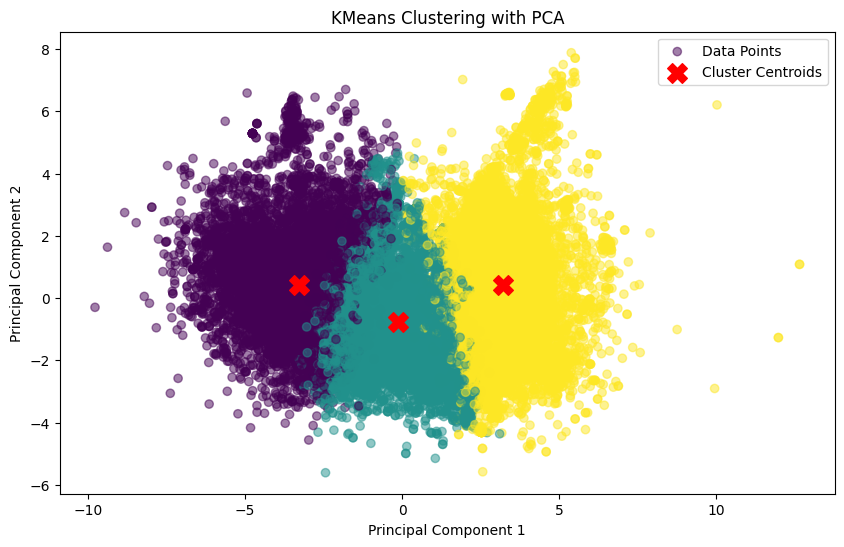

In [210]:
# Apply KMeans clustering
model_new = KMeans(n_clusters=3)
model_new.fit(embeddings_df.iloc[:, :-3])  # Exclude the last two columns for clustering
labels = model_new.predict(embeddings_df.iloc[:, :-3])
cluster_centriods = model_new.cluster_centers_  # Get cluster centroids

# Apply PCA to reduce dimensions to 2 components
model_pca = PCA(n_components=3)
X_pca = model_pca.fit_transform(embeddings_df.iloc[:, :-3])

# Transform cluster centroids using PCA
cluster_centriods_pca = model_pca.transform(cluster_centriods)

# Plot 2D representation with KMeans clusters and centroids
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.5, label='Data Points')
plt.scatter(cluster_centriods_pca[:, 0], cluster_centriods_pca[:, 1], marker='X', s=200, c='red', label='Cluster Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering with PCA')
plt.legend()
plt.show()

In [229]:
def return_sorted(emails):
    ret_lst = []
    for i in emails:
        test = process_text(i)
        test = get_embeddings(test)
    
        label = model_new.predict(test.reshape(1,100))
        test_pca = model_pca.transform(test.reshape(1,100))
        val = test_pca @ cluster_centriods_pca[label[0]]
        ret_lst.append([val,i])
    return ret_lst

In [230]:
lst = return_sorted(emails)
sorted_emails = sorted(lst, key=lambda x: x[0], reverse=True)

# Print the sorted emails
for importance, email_text in sorted_emails:
    print(f"Importance: {importance[0]},\nEmail:\n{email_text}\n")

Importance: 11.864949226379395,
Email:
Subject: Your Account Has Been Suspended
Hello [Your Name],
We're sorry to inform you that your account has been suspended due to policy violations. Please contact our support team for more information.


Importance: 10.773971557617188,
Email:
Subject: Urgent Meeting Tomorrow
Hi team,
Just a quick heads up that we have an urgent meeting scheduled for tomorrow morning at 10 AM. The management wants to discuss the progress of the ongoing project and make some crucial decisions. Please make sure you come prepared with all the necessary information.
Best regards,
Alex

Importance: 10.57303237915039,
Email:
Subject: Your Recent Purchase
Dear [Your Name],
Thank you for your recent purchase. Your order has been confirmed and will be shipped soon. If you have any questions, please contact our customer support.


Importance: 9.061003684997559,
Email:
Subject: Important Project Update
Hi [Client's Name],
I hope this email finds you well. I wanted to provide